In [101]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import scipy
from scipy.stats import beta, norm
import abc
from matplotlib.patches import PathPatch

In [56]:
# mmint
data_path = '/home/mmint/Desktop/drawing_evaluation'
datalegend_path =  os.path.join(data_path, 'drawing_evaluation_DataLegend.csv')
# mik:
# data_path = '/Users/mik/Desktop/bubble_files/drawing_evaluation'
# datalegend_path = os.path.join(data_path, 'drawing_evaluation_DataLegend.csv')

loaded_df = pd.read_csv(datalegend_path) # Original data from file

print(len(loaded_df))

611


In [57]:
# USEFUL FUNCTIONS:
def load_drawing(fc, scene_name):
    file_path = os.path.join(data_path, scene_name, 'measured_drawing', 'color_data', '{}_color_{:06d}.npy'.format(scene_name, fc))
    with open(file_path, 'rb') as f:
        drawing = np.load(f)
    return drawing
    
def load_desired_drawing(fc, scene_name):
    file_path = os.path.join(data_path, scene_name, 'expected_drawing', 'color_data', '{}_color_{:06d}.npy'.format(scene_name, fc))
    with open(file_path, 'rb') as f:
        drawing = np.load(f)
    return drawing
    
def filter_img(img):
    tag_size = 150
    filtered_value = 0
    filtered_img = img.copy()
    filtered_img[:tag_size, :tag_size] = filtered_value
    filtered_img[:tag_size, -tag_size:] = filtered_value
    filtered_img[-tag_size:, :tag_size] = filtered_value
    filtered_img[-tag_size:, -tag_size:] = filtered_value
    return filtered_img

def add_new_cost_function(df, cost_function, name):
    new_scores = []
    for i, row_i in df.iterrows():
        fc = row_i['EvaluationFileCode']
        scene_name = row_i['SceneName']
        drawn_img_i = load_drawing(fc, scene_name)
        desired_img_i = load_desired_drawing(fc, scene_name)
        filtered_img_i = filter_img(drawn_img_i)
        score_i = cost_function(filtered_img_i, desired_img_i)
        new_scores.append(score_i)
    df['{}_scores'.format(name)] = new_scores
    return df

In [58]:
# SCORE FUNCTIONS:
def compute_line_mask_score(actual_drawing, desired_drawing):
    actual_drawing_filtered = actual_drawing[30:-30, 100:-80] # remove borders for possible reflections or tags.
    desired_drawing_filtered = desired_drawing[30:-30, 100:-80] # remove borders for possible reflections or tags.
    actual_drawing_line = np.sum(actual_drawing_filtered, axis=1)
    desired_drawing_line = np.sum(desired_drawing_filtered, axis=1)
    actual_drawing_norm = np.divide(actual_drawing_line.astype(np.float32), actual_drawing_line.astype(np.float32), out=np.zeros_like(actual_drawing_line, dtype=np.float32), where=actual_drawing_line!=0)
    desired_drawing_norm = np.divide(desired_drawing_line.astype(np.float32), desired_drawing_line.astype(np.float32), out=np.zeros_like(desired_drawing_line, dtype=np.float32), where=desired_drawing_line!=0)
    score = np.sum(desired_drawing_norm * actual_drawing_norm)/np.sum(desired_drawing_norm)
    return score



### Plotting Functions

In [59]:
sns.set(rc = {'figure.figsize':(30,8)}, font_scale=2)


class ScorePlotBase(object):
    def __init__(self, palette=None):
        self.palette = palette
    
    def _filter_df(self, df, add_args):
        return df
    
    @abc.abstractmethod
    def _plot_df(self, df, score_name, object_name, hue):
        pass
    
    def _customize_ax(self, ax, add_args):
        return ax
    
    def __call__(self, df, score_name, object_name=None, hue=None):
        add_args = {'score_name': score_name, 'object_name': object_name, 'hue': hue}
        data_df, add_args = self._filter_df(df, add_args)
        ax = self._plot_df(data_df, score_name, object_name, hue)
        ax = self._customize_ax(ax, add_args)
        
        return ax
    
    
class ScorePlot(ScorePlotBase):
    def _filter_df(self, df, add_args):
        object_name = add_args['object_name']
        if object_name is not None:
            if type(object_name) in [str]:
                data_df = df[df.ObjectName == object_name]
            elif type(object_name) in [list, tuple, np.ndarray]:
                data_df = df[df.ObjectName.isin(object_name)]
            else:
                raise AttributeError('Argument Not supported {} type {}'.format(object_name, type(object_name)))
        else:
            data_df = df
            object_name = np.unique(df.ObjectName) # All object names
            
        add_args['object_name'] = object_name
        return data_df, add_args
    
    def _customize_ax(self, ax, add_args):
        object_name = add_args['object_name']
        ax.set_title('Object: {}'.format(object_name))
        if control_name_mapping is not None:
            current_labels = [label._text for label in ax.get_xticklabels()]
            mapped_labels = []
            for label in current_labels:
                if label in control_name_mapping:
                    mapped_label_i = control_name_mapping[label]
                else:
                    mapped_label_i = label
                mapped_label_i = mapped_label_i.replace(' ', '\n')
                mapped_labels.append(mapped_label_i)
            ax.set_xticklabels(mapped_labels)
        ax.set_ylabel('Drawing Score')
        return ax
    
    def _get_extra_arguments(self, df):
        extra_args = {}
        controllers = np.unique(df['ControllerMethod'])
        order = [m for m in model_order if m in controllers]
        extra_args['order'] = order
        extra_args['palette'] = self.palette
        return extra_args

class ScoreBoxPlot(ScorePlot):
    def __init__(self, *args, whis=1, **kwargs):
        self.whis = whis
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.boxplot(x='ControllerMethod', y=score_name, data=df, whis=self.whis, hue=hue, **extra_args)
        return ax
    
    
class ScoreBoxenPlot(ScorePlot):
    def __init__(self, *args, trust_alpha=0.05, **kwargs):
        self.trust_alpha = trust_alpha
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.boxenplot(x='ControllerMethod', y=score_name, data=df, hue=hue, trust_alpha=self.trust_alpha,**extra_args)
        return ax

    
class ScoreViolinPlot(ScorePlot):
    def __init__(self, *args, bw=1, cut=2, **kwargs):
        self.bw = bw
        self.cut = cut
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.violinplot(x='ControllerMethod', y=score_name, data=df, bw=self.bw, hue=hue, cut=self.cut, 
                            **extra_args)
        return ax

    
class ScoreStripPlot(ScorePlot):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.pointplot(x='ControllerMethod', y=score_name, data=df, join=False, dodge=True, alpha=0.1, markers="d", hue=hue, label=None, 
                           **extra_args)
        ax = sns.stripplot(x='ControllerMethod', y=score_name, data=df, hue=hue, jitter=True, 
                           **extra_args)
        ax.legend_.remove()
        return ax
    
class ScoreSwarmPlot(ScorePlot):
    def __init__(self, *args, size=5, **kwargs):
        self.size = size
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.swarmplot(x='ControllerMethod', y=score_name, data=df, hue=hue, size=self.size, 
                           **extra_args)
        return ax
    
class ScoreHistPlot(ScorePlot):
    def __init__(self, *args, bins='auto', **kwargs):
        self.bins = bins
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
#         ax = sns.histplot(y='ControllerMethod', x=score_name, data=df, hue='ControllerMethod', bins=self.bins, palette=self.palette,  hue_order=model_order, legend=False)
        ax = sns.histplot(y='ControllerMethod', x=score_name, data=df, bins=self.bins, hue=hue, legend=False, palette=self.palette)
#         palette = sns.color_palette("flare")
#         ax = sns.histplot(x='ControllerMethod', y=score_name, data=df, bins=self.bins)
        
        return ax 
    
    def _customize_ax(self, ax, add_args):
        object_name = add_args['object_name']
        ax.set_title('Object: {}'.format(object_name))
#         if control_name_mapping is not None:
#             current_labels = [label._text for label in ax.get_yticklabels()]
#             mapped_labels = []
#             for label in current_labels:
#                 if label in control_name_mapping:
#                     mapped_label_i = control_name_mapping[label]
#                 else:
#                     mapped_label_i = label
#                 mapped_labels.append(mapped_label_i)
#             ax.set_yticklabels(mapped_labels)
        ax.set_ylabel('Drawing Score')
        return ax
    

class CustomScoreMeanStdPlot(ScorePlot):
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        extra_args['palette'] = None
        ax = sns.pointplot(x='ControllerMethod', y=score_name, data=df, join=True, dodge=True, scale=1, markers="_", hue=hue,
                           label=None, ci='sd', errwidth=5, **extra_args, color='k', capsize=.5)
#         self._adjust_box_widths(ax, 0.1)
        return ax
    
    def _adjust_box_widths(self, ax, fac):
        """
        Adjust the withs of a seaborn-generated boxplot.
        """
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

### Pre-process the data:

In [60]:
loaded_df = add_new_cost_function(loaded_df, compute_line_mask_score, 'line_masked')
nan_indxs = loaded_df.index[loaded_df['line_masked_scores'].isnull()].tolist()
loaded_df = loaded_df.drop(nan_indxs)

/tmp/ipykernel_633798/4097221966.py:9: RuntimeWarning: invalid value encountered in float_scalars
  score = np.sum(desired_drawing_norm * actual_drawing_norm)/np.sum(desired_drawing_norm)


In [61]:
df_previous_icp = loaded_df[loaded_df.SceneName == 'line_drawing']
df_updated_icp = loaded_df[loaded_df.SceneName == 'line_drawing_updated_icp_approx']
random_df = loaded_df[loaded_df.ControllerMethod == 'random_action']

# Update the filtered df with the random control results
df_updated_icp_object = np.unique(df_updated_icp.ObjectName)
random_only_selected_objects = random_df[random_df.ObjectName.isin(df_updated_icp_object)]
df_updated_icp = pd.concat([df_updated_icp, random_only_selected_objects])

In [62]:
np.unique(df_updated_icp.ObjectName)
np.unique(df_updated_icp_object)

array(['amazon', 'crayola', 'expo_chisel', 'expo_ultra_fine', 'keebor',
       'loddie', 'magnetic', 'veesa', 'volcanics'], dtype=object)

In [63]:
# rename markers for scene name '<marker_name_1>_as_<marker_name_2>'
default_scene_name = 'line_drawing_updated_icp_approx'
all_scene_names = np.unique(loaded_df.SceneName)
scenes_names_cheat_marker = [sn for sn in all_scene_names if '_as_' in sn]
scenes_names_cheat_marker
# replace them for the marker name 
for sn_i in scenes_names_cheat_marker:
    loaded_df.loc[loaded_df.SceneName == sn_i, 'ObjectName'] = sn_i
    loaded_df.loc[loaded_df.SceneName == sn_i, 'SceneName'] = default_scene_name

In [64]:
all_object_names = np.unique(loaded_df.ObjectName)
all_object_names

array(['amazon', 'crayola', 'expo_chisel', 'expo_ultra_fine',
       'expo_ultra_fine_as_amazon', 'expo_ultra_fine_as_magnetic',
       'keebor', 'loddie', 'loddie_as_crayola', 'magnetic', 'veesa',
       'veesa_as_amazon', 'volcanics', 'volcanics_as_amazon',
       'volcanics_as_keebor'], dtype=object)

### Names and Colors Codes:

Rename marker from test with different object code

In [65]:
# DEFINE MODEL-CONTROL NAMES AND THEIR LABES TO BE DISPLAYED ON THE PLOTS:
control_name_mapping = None
learned_models = ['bubble_dynamics_model_mppi','bubble_linear_dynamics_model_mppi','object_pose_dynamics_model_mppi']
not_learned_models = ['bubble_dynamics_fixed_model_mppi','random_action']

control_name_mapping_base = {
    'bubble_dynamics_model_mppi':'Bubble Dynamics (Train)',
    'bubble_linear_dynamics_model_mppi': 'Bubble Linear Dynamics (Train)',
    'object_pose_dynamics_model_mppi': 'Object Pose Dynamics (Train)',
    'bubble_dynamics_fixed_model_mppi': 'Fixed Model (Train)',
    'random_action': 'Random (Train)',
    
}
control_name_mapping_test = {
    'bubble_dynamics_model_mppi_test':'Bubble Dynamics (Test)',
    'bubble_linear_dynamics_model_mppi_test': 'Bubble Linear Dynamics (Test)',
    'object_pose_dynamics_model_mppi_test': 'Object Pose Dynamics (Test)',
    'bubble_dynamics_fixed_model_mppi_test': 'Fixed Model (Test)',
    'random_action_test': 'Random (Test)',
}
control_name_mapping = control_name_mapping_base.copy()
control_name_mapping.update(control_name_mapping_test)

In [66]:
# DEFINE THE MODEL-CONTROL ORDER TO BE DISPLAYED ON THE PLOTS:

model_order = None

def intercalar_dicts_keys(dict_list):
    out = []
    lens = [len(d_i) for d_i in dict_list]
    for i in range(np.max(lens)):
        for d_i in dict_list:
            if i < len(d_i):
                out.append(list(d_i.keys())[i])
    return out
model_order = intercalar_dicts_keys([control_name_mapping_base, control_name_mapping_test])

In [67]:
# DEFINE OBJECT NAMES AND THEIR CATEGORIES ----------

train_objects = ['amazon', 'keebor', 'crayola', 'expo_chisel', 'magnetic']
test_objects = ['veesa', 'volcanics', 'loddie']
cheat_object_name_mapping = {
    'veesa': 'veesa_as_amazon',
    'loddie': 'loddie_as_crayola',
    'volcanics': 'volcanics_as_keebor'
}
cheat_object_name_mapping_reversed = dict(zip(cheat_object_name_mapping.values(),cheat_object_name_mapping.keys()))
all_objects = train_objects + test_objects
test_objects_w_cheat = test_objects + [cheat_object_name_mapping[k] for k in all_objects if k in cheat_object_name_mapping]


In [68]:
## DEFINE THE PALETTES -------------------------------

palette = None
base_palette = sns.color_palette("tab10")
palette = dict(zip(all_objects,[base_palette[o_i] for o_i, obj_i in enumerate(all_objects)]))
# add model names to it:
model_palette_list = [c_i for c_i in sns.color_palette('Set2')] + [c_i for c_i in sns.color_palette("husl", 8)]


object_palette_list = sns.color_palette("tab10")[:5]+sns.color_palette("pastel")[:]


palette = {}
# Model palette
for i, control_name_i in enumerate(control_name_mapping.keys()):
    palette[control_name_i] = model_palette_list[i]
    
# Object name palette
for i, obj_name_i in enumerate(all_objects):
    palette[obj_name_i] = object_palette_list[i]

### Clean Data -- Filter out + rename

In [69]:
np.unique(loaded_df.ObjectName)

array(['amazon', 'crayola', 'expo_chisel', 'expo_ultra_fine',
       'expo_ultra_fine_as_amazon', 'expo_ultra_fine_as_magnetic',
       'keebor', 'loddie', 'loddie_as_crayola', 'magnetic', 'veesa',
       'veesa_as_amazon', 'volcanics', 'volcanics_as_amazon',
       'volcanics_as_keebor'], dtype=object)

In [70]:
# Rename data for 
base_df = loaded_df
learned_model_data = base_df[base_df.ControllerMethod.isin(learned_models)]
not_learned_model_data = base_df[base_df.ControllerMethod.isin(not_learned_models)]


train_data_learned = learned_model_data[learned_model_data.ObjectName.isin(train_objects)]
train_data_fixed_random = not_learned_model_data[not_learned_model_data.ObjectName.isin(train_objects)]
cheat_object_keys = [cheat_object_name_mapping[k] for k in test_objects]
test_data_learned = learned_model_data[learned_model_data.ObjectName.isin(cheat_object_keys)]
test_data_fixed_random = not_learned_model_data[not_learned_model_data.ObjectName.isin(test_objects)]
# map the data from test learned to the basic names
test_data_learned = test_data_learned.replace({'ObjectName': cheat_object_name_mapping_reversed})

# map the methods on 
train_data = pd.concat([train_data_learned, train_data_fixed_random], ignore_index=True)
test_data = pd.concat([test_data_learned, test_data_fixed_random], ignore_index=True)

test_data['ControllerMethod'] = test_data['ControllerMethod'] + '_test'

filtered_data = pd.concat([train_data, test_data], ignore_index=True)


In [84]:
def downsample_methods(df, max_num_samples=10):
    controllers = np.unique(df.ControllerMethod)
    object_names = np.unique(df.ObjectName)
    downsampled_df = df.copy()
    all_indxs_to_drop = []
    for controller in controllers:
        df_controller_i = df[df.ControllerMethod == controller]
        for object_name in object_names:
            df_i = df_controller_i[df_controller_i.ObjectName == object_name]
            num_samples = len(df_i)
            if num_samples > max_num_samples:
                # downsample the dataframe
                num_extra_samples = num_samples - max_num_samples
                indx_to_drop = np.random.randint(0,num_samples, num_extra_samples)
                general_indxs_to_drop = [df_i.iloc[indx].name for indx in indx_to_drop]
                all_indxs_to_drop = all_indxs_to_drop + general_indxs_to_drop
    downsampled_df = downsampled_df.drop(axis=0, index=all_indxs_to_drop)
            
    return downsampled_df

downsampled_df = downsample_methods(filtered_data)

In [85]:
test_data_learned

,EvaluationFileCode,ReferenceFileCode,ActionsFileCode,ObjectName,SceneName,ControllerMethod,ObjectPoseEstimator,Score,NumSteps,NumStepsExpected,ObservationFileCodes,line_masked_scores
406,8984,8957,8984,volcanics,line_drawing_updated_icp_approx,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,80.434863,25,40,"[8958, 8959, 8960, 8961, 8962, 8963, 8964, 896...",0.476950
407,9012,8985,9012,volcanics,line_drawing_updated_icp_approx,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,32.497306,25,40,"[8986, 8987, 8988, 8989, 8990, 8991, 8992, 899...",0.458407
408,9041,9013,9041,veesa,line_drawing_updated_icp_approx,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,31.517313,26,40,"[9014, 9015, 9016, 9017, 9018, 9019, 9020, 902...",0.461812
409,9069,9053,9069,veesa,line_drawing_updated_icp_approx,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,101.166410,14,40,"[9054, 9055, 9056, 9057, 9058, 9059, 9060, 906...",0.349291
410,9111,9070,9111,veesa,line_drawing_updated_icp_approx,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,9.078498,39,40,"[9071, 9072, 9073, 9074, 9075, 9076, 9077, 907...",0.842199
...,...,...,...,...,...,...,...,...,...,...,...,...
606,14245,14214,14245,loddie,line_drawing_updated_icp_approx,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,14.473569,29,40,"[14215, 14216, 14217, 14218, 14219, 14220, 142...",0.769504
607,14265,14246,14265,loddie,line_drawing_updated_icp_approx,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,54.610371,17,40,"[14247, 14248, 14249, 14250, 14251, 14252, 142...",0.556738
608,14283,14266,14283,loddie,line_drawing_updated_icp_approx,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,149.501715,15,40,"[14267, 14268, 14269, 14270, 14271, 14272, 142...",0.276106
609,14307,14284,14307,loddie,line_drawing_updated_icp_approx,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,94.837538,21,40,"[14285, 14286, 14287, 14288, 14289, 14290, 142...",0.434397


# Plot 

In [86]:
score_box_plot = ScoreBoxPlot(palette=palette)
score_violin_plot = ScoreViolinPlot(palette=palette, bw=0.2,cut=0)
score_boxen_plot = ScoreBoxenPlot(palette=palette)
score_strip_plot = ScoreStripPlot(palette=palette)
score_swarm_plot = ScoreSwarmPlot(palette=palette, size=15)
custom_score_mean_std_plot = CustomScoreMeanStdPlot(palette=palette)
score_hist_plot = ScoreHistPlot(palette=palette, bins='doane')

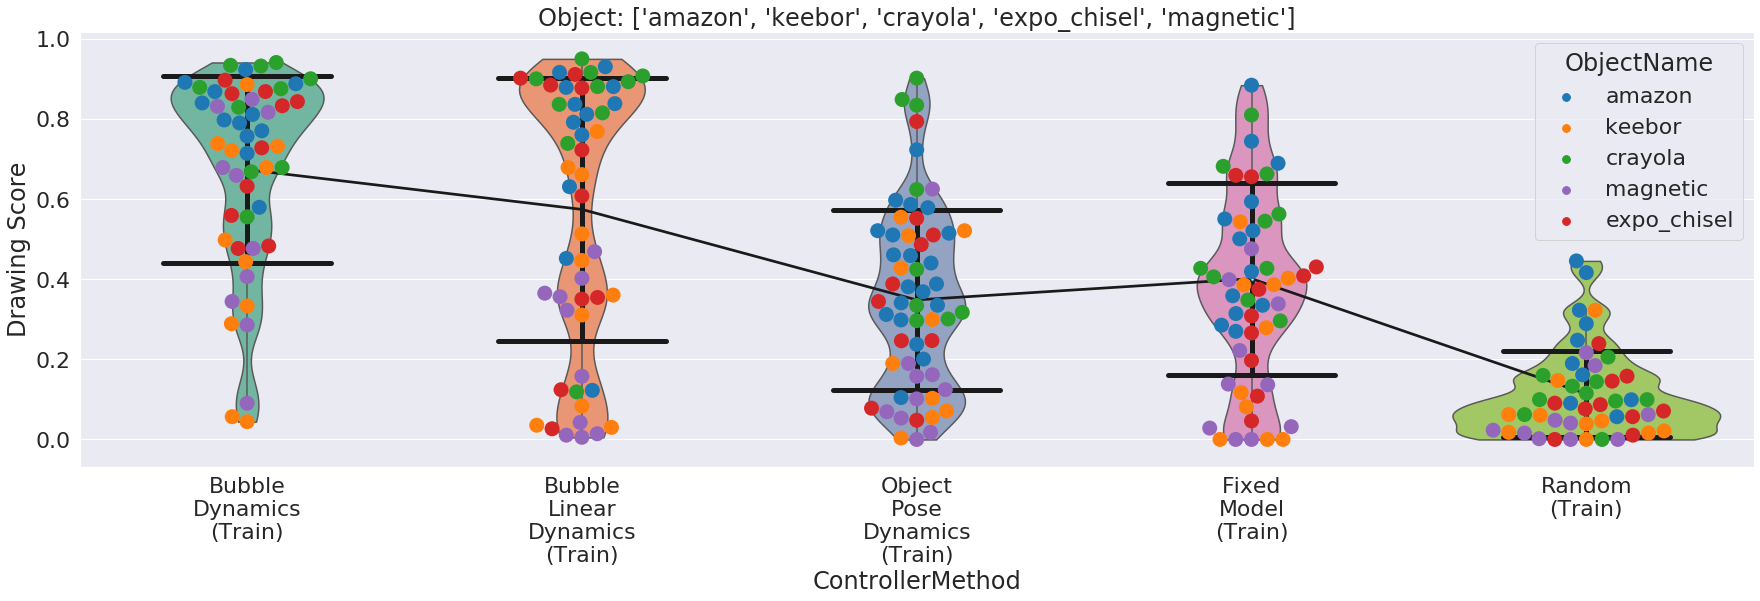

In [87]:
ax = score_violin_plot(filtered_data, 'line_masked_scores', object_name=train_objects) # ALL
# ax_2 = score_swarm_plot(filtered_data, 'line_masked_scores', object_name=train_objects, hue='ObjectName')
ax_2 = score_swarm_plot(downsampled_df, 'line_masked_scores', object_name=train_objects, hue='ObjectName')
ax_3 = custom_score_mean_std_plot(filtered_data, 'line_masked_scores', object_name=train_objects)

In [80]:
np.unique(filtered_data.ObjectName)

array(['amazon', 'crayola', 'expo_chisel', 'keebor', 'loddie', 'magnetic',
       'veesa', 'volcanics'], dtype=object)

In [81]:
np.unique(filtered_data.ControllerMethod)

array(['bubble_dynamics_fixed_model_mppi',
       'bubble_dynamics_fixed_model_mppi_test',
       'bubble_dynamics_model_mppi', 'bubble_dynamics_model_mppi_test',
       'bubble_linear_dynamics_model_mppi',
       'bubble_linear_dynamics_model_mppi_test',
       'object_pose_dynamics_model_mppi',
       'object_pose_dynamics_model_mppi_test', 'random_action',
       'random_action_test'], dtype=object)

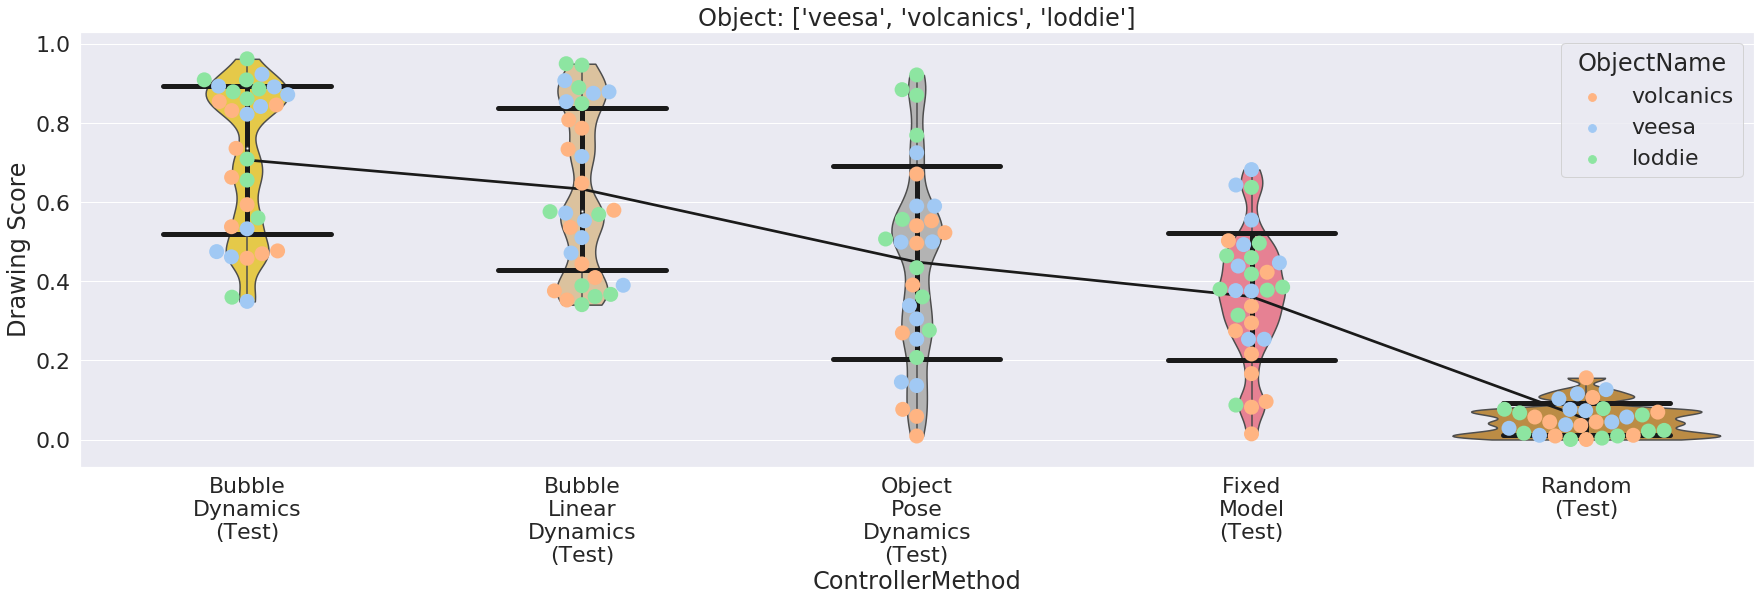

In [91]:
ax = score_violin_plot(filtered_data, 'line_masked_scores', object_name=test_objects) # ALL
# ax_2 = score_swarm_plot(filtered_data, 'line_masked_scores', object_name=test_objects, hue='ObjectName')
ax_2 = score_swarm_plot(downsampled_df, 'line_masked_scores', object_name=test_objects, hue='ObjectName')
ax_3 = custom_score_mean_std_plot(filtered_data, 'line_masked_scores', object_name=test_objects)

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


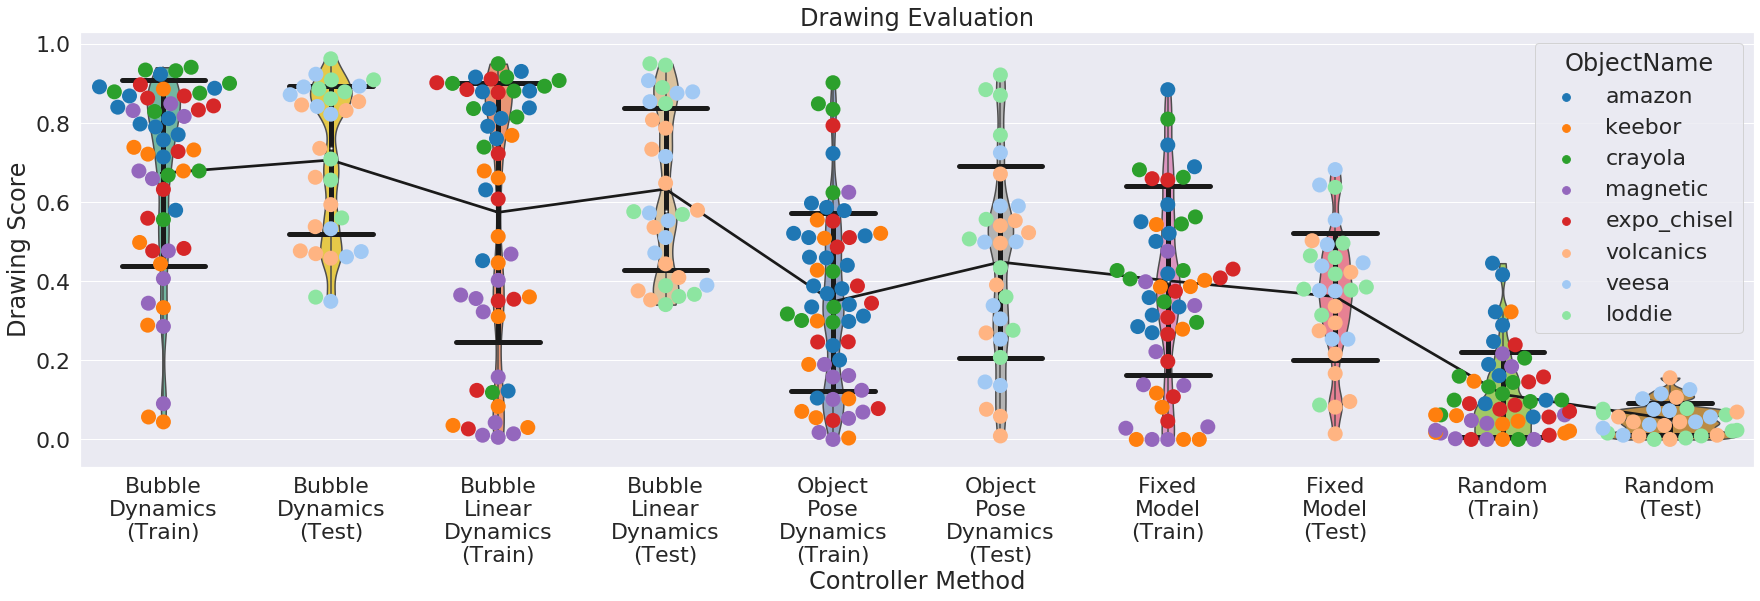

In [89]:
ax = score_violin_plot(filtered_data, 'line_masked_scores', object_name=all_objects) # ALL
# ax_2 = score_swarm_plot(filtered_data, 'line_masked_scores', object_name=all_objects, hue='ObjectName')
ax_2 = score_swarm_plot(downsampled_df, 'line_masked_scores', object_name=all_objects, hue='ObjectName')
ax_3 = custom_score_mean_std_plot(filtered_data, 'line_masked_scores', object_name=all_objects)
ax.set_title('Drawing Evaluation')
ax.set_xlabel('Controller Method')



fig = ax.get_figure()
plot_path = os.path.join(data_path, 'evaluation_plots')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(os.path.join(plot_path, 'drawing_evaluation.pdf'), bbox_inches='tight')

# DISTRIBUTION FITTING:

In [96]:
# DISTRIBUTION FITTING:

from collections import defaultdict


controller_methods = np.unique(filtered_data.ControllerMethod)
metric_data = defaultdict(list)
for controller_method in controller_methods:
    scores_i = filtered_data[filtered_data['ControllerMethod'] == controller_method].line_masked_scores.values
    metric_data['controller_method'].append(controller_method)
    metric_data['sample_mean'].append(np.mean(scores_i))
    metric_data['sample_std'].append(np.std(scores_i))
    # fit gaussian to samples.
    norm_mean, norm_std = norm.fit(scores_i)
    metric_data['fitted_gaussian_mean'].append(norm_mean)
    metric_data['fitted_gaussian_std'].append(norm_std)
    
    # fit beta
    beta_params = beta.fit(scores_i)
    a, b, loc, scale = beta_params
    beta_mean = a/(a+b)
    beta_std = np.sqrt(a*b/((a+b)**2*(a + b + 1)))
    metric_data['fitted_beta_mean'].append(beta_mean)
    metric_data['fitted_beta_std'].append(beta_std)
    metric_data['fitted_beta_alpha'].append(a)
    metric_data['fitted_beta_beta'].append(b)

metric_df = pd.DataFrame(metric_data)

metric_df

/usr/local/lib/python3.8/dist-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


,controller_method,sample_mean,sample_std,fitted_gaussian_mean,fitted_gaussian_std,fitted_beta_mean,fitted_beta_std,fitted_beta_alpha,fitted_beta_beta
0,bubble_dynamics_fixed_model_mppi,0.401450,0.239433,0.401450,0.239433,0.380147,0.273948,0.813446,1.326377
1,bubble_dynamics_fixed_model_mppi_test,0.361418,0.159592,0.361418,0.159592,0.531185,0.204872,2.620388,2.312710
2,bubble_dynamics_model_mppi,0.673920,0.234505,0.673920,0.234505,0.748574,0.243547,1.626701,0.546365
3,bubble_dynamics_model_mppi_test,0.706830,0.188125,0.706830,0.188125,0.588111,0.334866,0.682339,0.477882
4,bubble_linear_dynamics_model_mppi,0.574499,0.327640,0.574499,0.327640,0.601320,0.362617,0.495004,0.328191
5,bubble_linear_dynamics_model_mppi_test,0.633342,0.205635,0.633342,0.205635,0.514381,0.339742,0.598805,0.565322
6,object_pose_dynamics_model_mppi,0.348436,0.225370,0.348436,0.225370,0.393238,0.264850,0.944367,1.457150
7,object_pose_dynamics_model_mppi_test,0.448741,0.243911,0.448741,0.243911,0.524305,0.287747,1.055037,0.957222
8,random_action,0.113888,0.106730,0.113888,0.106730,0.110750,0.114491,0.721347,5.791922
9,random_action_test,0.052003,0.040031,0.052003,0.040031,0.163128,0.144710,0.900330,4.618816


In [98]:
raw_string = metric_df.to_latex()
lines = raw_string.split('\n')
for line in lines:
    print(line)

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                       controller\_method &  sample\_mean &  sample\_std &  fitted\_gaussian\_mean &  fitted\_gaussian\_std &  fitted\_beta\_mean &  fitted\_beta\_std &  fitted\_beta\_alpha &  fitted\_beta\_beta \\
\midrule
0 &        bubble\_dynamics\_fixed\_model\_mppi &     0.401450 &    0.239433 &              0.401450 &             0.239433 &          0.380147 &         0.273948 &           0.813446 &          1.326377 \\
1 &   bubble\_dynamics\_fixed\_model\_mppi\_test &     0.361418 &    0.159592 &              0.361418 &             0.159592 &          0.531185 &         0.204872 &           2.620388 &          2.312710 \\
2 &              bubble\_dynamics\_model\_mppi &     0.673920 &    0.234505 &              0.673920 &             0.234505 &          0.748574 &         0.243547 &           1.626701 &          0.546365 \\
3 &         bubble\_dynamics\_model\_mppi\_test &     0.706830 &    0.188125 &              0.706830 &            

In [99]:
def beta_plots(metrics_df):
    
    fig, axes = plt.subplots(2, 1)
    
    x = np.linspace(0, 1, 100)
    
    ax_1 = axes[0]
    ax_2 = axes[1]
    
    
    for i, line in metrics_df.iterrows():
        controller_method = line['controller_method']
        label_i = control_name_mapping[controller_method]
        beta_mean_i = line['fitted_beta_mean']
        sample_mean_i = line['sample_mean']
        color_i = np.array(palette[controller_method])
#         ax.hist(scores, label=label_i, color=color_i, alpha=0.2)
#         ax_1.plot(x, beta.pdf(x, a, b), label=label_i, color=color_i, lw=10.0)
        ax_1.axvline(x=beta_mean_i, color=color_i, lw=15.0, label=label_i)
        ax_2.axvline(x=sample_mean_i, color=color_i, lw=15.0, label=label_i)
        
#     ax_1.legend()
    ax_1.set_xlabel('beta_mean')
    ax_2.legend()
    ax_2.set_xlabel('sample_mean')
        
    return axes

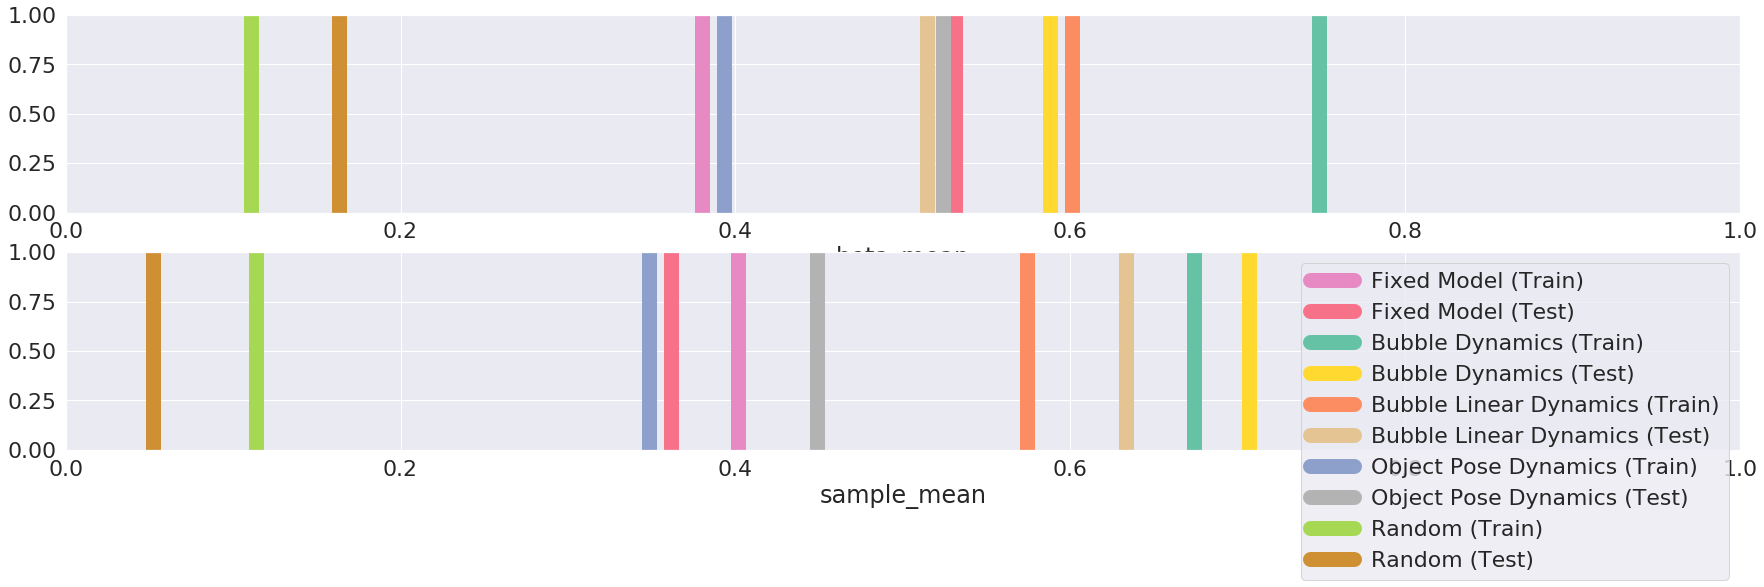

In [100]:
axes = beta_plots(metric_df)